In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm 

import astropy.units as u
from astropy.utils.data import download_file 
from astropy.io import fits #We use fits to open the actual data file

from astropy.utils import data
data.conf.remote_timeout = 60

from spectral_cube import SpectralCube 

from astroquery.esasky import ESASky
from astroquery.utils import TableList
from astropy.wcs import WCS
from reproject import reproject_interp

In [2]:
data = fits.open("NGC1313/ADP.2019-11-29T11:13:19.106.fits")
cube = SpectralCube.read(data[1])

In [3]:
print(cube)

SpectralCube with shape=(3801, 309, 317) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    317  type_x: RA---TAN  unit_x: deg    range:    49.560879 deg:   49.604896 deg
 n_y:    309  type_y: DEC--TAN  unit_y: deg    range:   -66.495049 deg:  -66.477937 deg
 n_s:   3801  type_s: AWAV      unit_s: Angstrom  range:     4599.915 Angstrom:    9349.915 Angstrom


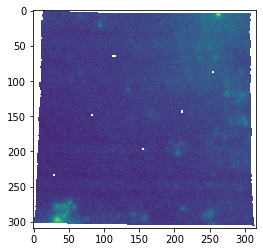

In [4]:
cube[300, :, :].quicklook() #slice the cube along the spectral azis, and display a quick image

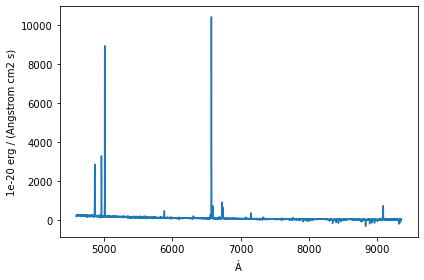

In [14]:
cube[:, 275, 50].quicklook() #extract a single spectrum through the data cube
plt.tight_layout()
plt.savefig("NGC1313_spectrum.jpg")

In [6]:
_, b, _ = cube.world[0, :, 0] #extract latitude world coordinates from cube
_, _, l = cube.world[0, 0, :] #extract longitude world coordinates from cube

In [7]:
#define desired latitude and longitude range
lat_range = [0, 309]*u.deg
lon_range = [317,0]*u.deg 

#create a sub_cube cut to these coordinates (realmente usaremos el cubo completo)
sub_cube = cube.subcube(xlo=lon_range[0], xhi=lon_range[1], ylo=lat_range[0], yhi=lat_range[1])
sub_cube

SpectralCube with shape=(3801, 309, 317) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    317  type_x: RA---TAN  unit_x: deg    range:   182.102696 deg:  182.102696 deg
 n_y:    309  type_y: DEC--TAN  unit_y: deg    range:   -16.386227 deg:  -16.386227 deg
 n_s:   3801  type_s: AWAV      unit_s: Angstrom  range:     4599.915 Angstrom:    9349.915 Angstrom

In [50]:
sub_cube_slab = cube.spectral_slab(6500 *u.AA, 6700 *u.AA)
print(sub_cube_slab)

SpectralCube with shape=(161, 309, 317) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    317  type_x: RA---TAN  unit_x: deg    range:    49.560879 deg:   49.604896 deg
 n_y:    309  type_y: DEC--TAN  unit_y: deg    range:   -66.495049 deg:  -66.477937 deg
 n_s:    161  type_s: AWAV      unit_s: Angstrom  range:     6499.915 Angstrom:    6699.915 Angstrom


In [51]:
ha_cube = sub_cube_slab.with_spectral_unit(u.km/u.s, velocity_convention="optical", rest_value=6563*u.AA)
ha_subcube = ha_cube.spectral_slab(-30*u.km/u.s, 5*u.km/u.s)

In [52]:
#moment map 0 y 1 para H alfa
moment_0 = sub_cube_slab.with_spectral_unit(u.AA).moment(order=0) #zero-th moment
moment_1 = sub_cube_slab.with_spectral_unit(u.AA).moment(order=1) #first moment

# write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

print("moment_0 has units of: ", moment_0.unit)
print("moment_1 has units of: ", moment_1.unit)

hi_column_density = moment_0 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

/Users/belen/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


moment_0 has units of:  1e-20 erg / (cm2 s)
moment_1 has units of:  Angstrom


In [53]:
print(moment_1.wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 49.582926  -66.48651  
CRPIX : 158.723254736559  154.721252565867  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.55555555555556e-05  5.55555555555556e-05  
NAXIS : 0  0


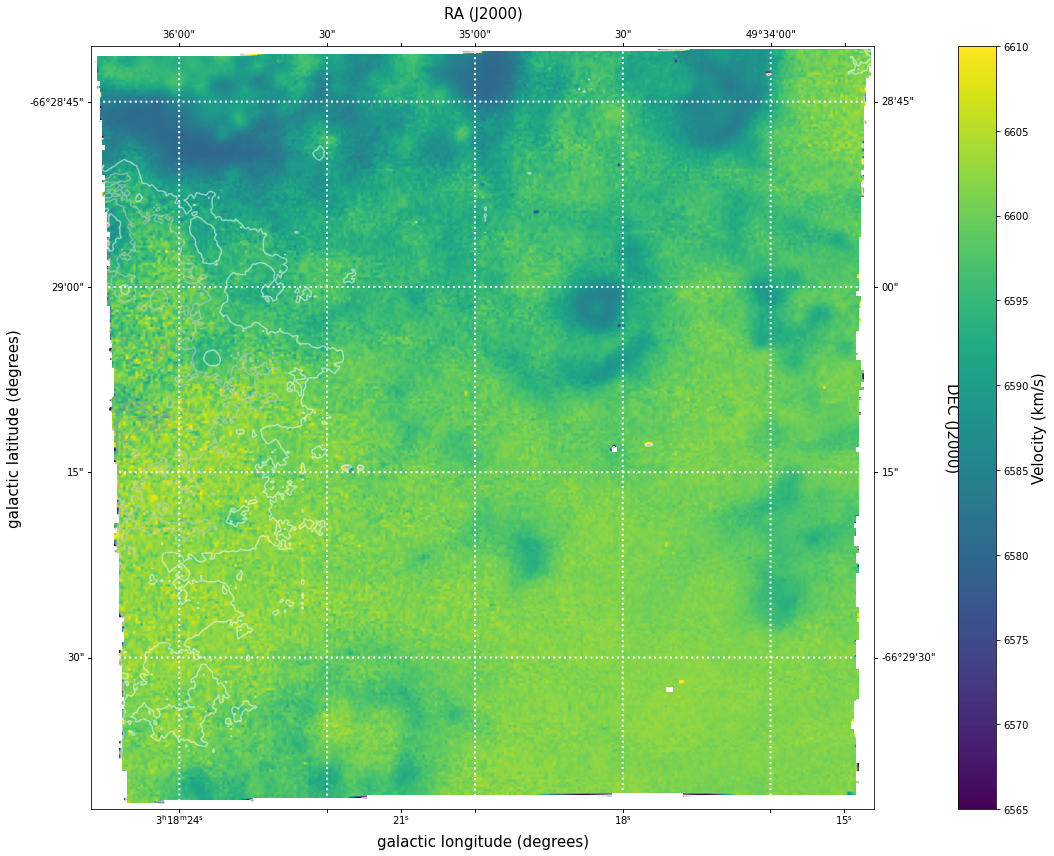

In [55]:
# initiate a figure and axis objects with WCS projection information
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection=moment_1.wcs)

# display the moment map image
im = ax.imshow(moment_1.hdu.data, cmap = "viridis", vmin=6565, vmax=6610)
#ax.invert_yaxis() flip the y axis

#add axes labels
ax.set_xlabel("galactic longitude (degrees)", fontsize = 15)
ax.set_ylabel("galactic latitude (degrees)", fontsize = 15)

#add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label("Velocity (km/s)", size=15)

#overlay set of RA/DEC axes
overlay = ax.get_coords_overlay("fk5")
overlay.grid(color="white", ls="dotted", lw=2)
overlay[0].set_axislabel("RA (J2000)", fontsize=15)
overlay[1].set_axislabel("DEC (J2000)", fontsize=15)

#overplot column density contours (CONTÍNUO ESTELAR)
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22) #define contour level to use
ax.contour(hi_column_density.hdu.data, cmap="Greys_r", alpha=0.5, levels=levels)
plt.tight_layout()
plt.savefig("NGC1313_Halfa_velocity.jpg")

In [56]:
sub_cube_slab2 = cube.spectral_slab(4970 *u.AA, 5030 *u.AA)
print(sub_cube_slab)

SpectralCube with shape=(161, 309, 317) and unit=1e-20 erg / (Angstrom cm2 s):
 n_x:    317  type_x: RA---TAN  unit_x: deg    range:    49.560879 deg:   49.604896 deg
 n_y:    309  type_y: DEC--TAN  unit_y: deg    range:   -66.495049 deg:  -66.477937 deg
 n_s:    161  type_s: AWAV      unit_s: Angstrom  range:     6499.915 Angstrom:    6699.915 Angstrom


In [57]:
OIII_cube = sub_cube_slab2.with_spectral_unit(u.km/u.s, velocity_convention="optical", rest_value=5007*u.AA)
OIII_subcube = OIII_cube.spectral_slab(-30*u.km/u.s, 5*u.km/u.s)

In [58]:
#moment map 00 y 01 para O III
moment_00 = sub_cube_slab2.with_spectral_unit(u.AA).moment(order=0) #zero-th moment
moment_01 = sub_cube_slab2.with_spectral_unit(u.AA).moment(order=1) #first moment

# write the moments as a FITS image
# moment_0.write('hi_moment_0.fits') 
# moment_1.write('hi_moment_1.fits')

print("moment_00 has units of: ", moment_00.unit)
print("moment_01 has units of: ", moment_01.unit)

hi_column_density2 = moment_00 * 1.82 * 10**18 / (u.cm * u.cm) * u.s / u.K / u.km

/Users/belen/opt/anaconda3/lib/python3.8/site-packages/spectral_cube/_moments.py:168: RuntimeWarning: invalid value encountered in true_divide
  return (np.nansum(data * pix_cen, axis=axis) /


moment_00 has units of:  1e-20 erg / (cm2 s)
moment_01 has units of:  Angstrom


In [59]:
print(moment_01.wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 49.582926  -66.48651  
CRPIX : 158.723254736559  154.721252565867  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.55555555555556e-05  5.55555555555556e-05  
NAXIS : 0  0


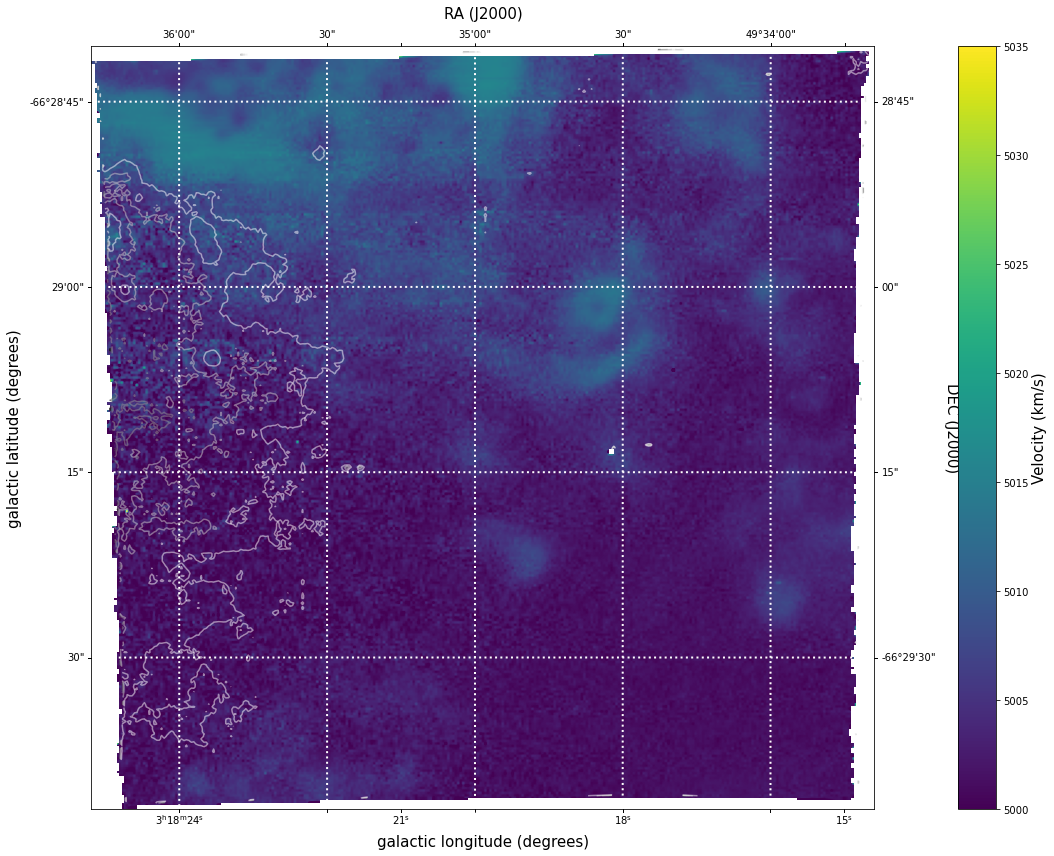

In [62]:
# initiate a figure and axis objects with WCS projection information
fig = plt.figure(figsize=(18,12))
ax = fig.add_subplot(111, projection=moment_01.wcs)

# display the moment map image
im = ax.imshow(moment_01.hdu.data, cmap = "viridis", vmin=5000, vmax=5035)
#ax.invert_yaxis() flip the y axis

#add axes labels
ax.set_xlabel("galactic longitude (degrees)", fontsize = 15)
ax.set_ylabel("galactic latitude (degrees)", fontsize = 15)

#add a colorbar
cbar = plt.colorbar(im, pad=.07)
cbar.set_label("Velocity (km/s)", size=15)

#overlay set of RA/DEC axes
overlay = ax.get_coords_overlay("fk5")
overlay.grid(color="white", ls="dotted", lw=2)
overlay[0].set_axislabel("RA (J2000)", fontsize=15)
overlay[1].set_axislabel("DEC (J2000)", fontsize=15)

#overplot column density contours (CONTÍNUO ESTELAR)
levels = (1e20, 5e20, 1e21, 3e21, 5e21, 7e21, 1e22) #define contour level to use
ax.contour(hi_column_density.hdu.data, cmap="Greys_r", alpha=0.5, levels=levels)
plt.tight_layout()
plt.savefig("NGC1487_OIII_velocity.jpg")